[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection


- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


## Highlights

- `tree_` attribute in the fitted decision tree
    - contains some useful information, such as `max_depth`
- `GridSearchCV`
    - implements *cross validation*, needs 
        - a *score to be optimized*
        - *ranges* of the hyperparameters to be optimized, the *parameters grid*
    - sets the values for `best_params_` and `best_estimator_`
- `classification_report`
- `ConfusionMatrixDisplay`



In [1]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

### Prepare the environment
Import libraries

Load the dataset `winequality-red-wi.csv`

Set the training set size and the random state

In [2]:
import seaborn as sns
import pandas as pd
train_size = 0.33
random_state = 42 

Read the data into a dataframe and show the size

In [3]:
df = pd.read_csv('winequality-red.csv', sep = ';')
df.size

19188

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [4]:
df.head(4)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

<AxesSubplot:xlabel='quality'>

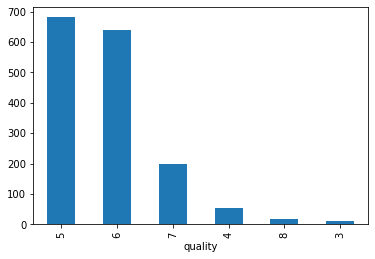

In [5]:
target = 'quality'
df.quality.value_counts().plot(kind='bar')

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [6]:
X = df.drop(target, axis=1)
X.shape

y = df[target]
y.shape

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= random_state, train_size = train_size)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(527, 11) (1072, 11) (527,) (1072,)


### Prepare the baseline: holdout method

In [7]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = random_state)
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=42)

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [8]:
from sklearn.metrics import accuracy_score

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [9]:
ytest_dt = model.predict(Xtest)                  # 4. predict on new data
accuracy_test = accuracy_score(ytest, ytest_dt)
print("The accuracy on test set is {0:.2f}%".format(accuracy_test * 100))

fitted_max_depth = model.get_depth()
parameter_values = range(1,fitted_max_depth+1)
print("The maximum depth of the tree fitted on X_train is {}".format(fitted_max_depth))

The accuracy on test set is 54.66%
The maximum depth of the tree fitted on X_train is 21


Prepare the decision tree parameters and the scores 

In [10]:
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]

# Set the different scores that will be optimised
scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification report`
    - display the confusion matrix with `ConfusionMatrixDisplay`

{'class_weight': None, 'criterion': 'gini', 'max_depth': 4}
DecisionTreeClassifier(max_depth=4, random_state=42)
0.6205929919137466
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        35
           5       0.65      0.75      0.70       464
           6       0.52      0.58      0.55       416
           7       0.59      0.30      0.40       138
           8       0.00      0.00      0.00        15

    accuracy                           0.59      1072
   macro avg       0.29      0.27      0.27      1072
weighted avg       0.56      0.59      0.57      1072



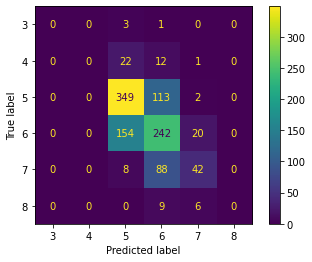

{'class_weight': None, 'criterion': 'gini', 'max_depth': 11}
DecisionTreeClassifier(max_depth=11, random_state=42)
0.393605429364607
              precision    recall  f1-score   support

           3       0.07      0.25      0.11         4
           4       0.00      0.00      0.00        35
           5       0.68      0.62      0.65       464
           6       0.53      0.63      0.57       416
           7       0.46      0.33      0.39       138
           8       0.00      0.00      0.00        15

    accuracy                           0.56      1072
   macro avg       0.29      0.31      0.29      1072
weighted avg       0.56      0.56      0.55      1072



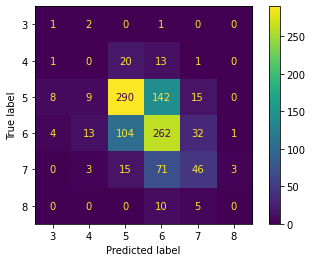

{'class_weight': None, 'criterion': 'gini', 'max_depth': 11}
DecisionTreeClassifier(max_depth=11, random_state=42)
0.3587723688886479
              precision    recall  f1-score   support

           3       0.07      0.25      0.11         4
           4       0.00      0.00      0.00        35
           5       0.68      0.62      0.65       464
           6       0.53      0.63      0.57       416
           7       0.46      0.33      0.39       138
           8       0.00      0.00      0.00        15

    accuracy                           0.56      1072
   macro avg       0.29      0.31      0.29      1072
weighted avg       0.56      0.56      0.55      1072



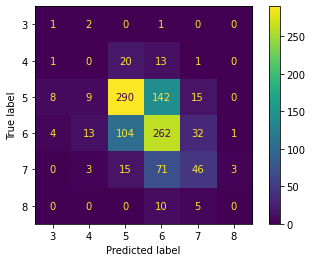

{'class_weight': None, 'criterion': 'gini', 'max_depth': 9}
DecisionTreeClassifier(max_depth=9, random_state=42)
0.3542701840419039
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.04      0.03      0.03        35
           5       0.66      0.68      0.67       464
           6       0.54      0.59      0.56       416
           7       0.50      0.36      0.42       138
           8       0.00      0.00      0.00        15

    accuracy                           0.57      1072
   macro avg       0.29      0.28      0.28      1072
weighted avg       0.56      0.57      0.56      1072



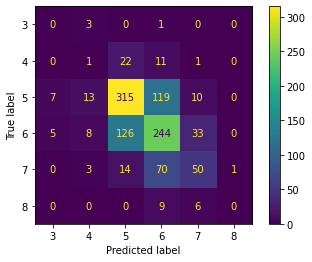

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for s in scores:
    grid = GridSearchCV(estimator=model, param_grid=tuned_param_dt, scoring=s)
    grid.fit(Xtrain, ytrain)
    print(grid.best_params_)   
    print(grid.best_estimator_)
    print(grid.best_score_)
    clf = grid.best_estimator_
    predicted = clf.predict(Xtest)
    
    print(classification_report(ytest, predicted, labels=clf.classes_))
    
    cm = confusion_matrix(ytest, predicted, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()
    

In [12]:
clf.best_params_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'best_params_'